In [98]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

import collections
import hashlib
import numbers
import matplotlib.cm as cm

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear

In [2]:
# uplading mnist data 

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [112]:
# Training Parameters
learning_rate = 1e-5
training_steps = 5000
batch_size = 128
display_step = 200
test_len=128
grad_clip=200
# Network Parameters
num_input = 1 # MNIST data input (img shape: 28*28)
timesteps = 28*28 # timesteps
num_hidden = 200 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input


create a tuple object for the cell, 

In [113]:
_KernelRNNStateTuple = collections.namedtuple("KernelRNNStateTuple", ("h","h_hat","Theta", "Gamma","input_trace","recurrent_trace","input_sensitivity","recurrent_sensitivity","kernel_coeff"))
_KernelRNNOutputTuple = collections.namedtuple("KernelRNNOutputTuple", ("h","h_hat","Theta","Gamma", "input_trace","recurrent_trace"))

class KernelRNNStateTuple(_KernelRNNStateTuple):
  """Tuple used by kernel RNN Cells for `state_variables `.
  Stores 9 elements: `(h, h_hat, Theta, Gamma, input_trace,recurrent_trace, input_sensitivity,recurrent_sensitivity, kernel_coeff`, in that order. 
  always is used for this type of cell
  """
  __slots__ = ()

  @property
  def dtype(self):
    (h, h_hat,Theta, Gamma, input_trace,recurrent_trace, input_sensitivity, recurrent_sensitivity, kernel_coeff ) = self
    if h.dtype != h_hat.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(h.dtype), str(h_hat.dtype)))
    return h_hat.dtype


class KernelRNNOutputTuple(_KernelRNNOutputTuple):
  """Tuple used by kernel Cells for output state.
  Stores 6 elements: `(h,h_hat, Theta, Gamma, input_trace, recurrent_trace)`, 
  Only used when `output_is_tuple=True`.
  """
  __slots__ = ()

  @property
  def dtype(self):
    (h, h_hat, Theta, Gamma, input_trace, recurrent_trace) = self
    if h.dtype != h_hat.dtype:
      raise TypeError("Inconsistent internal state: %s vs %s" %
                      (str(h.dtype), str(h_hat.dtype)))
    return h_hat.dtype


In [114]:
## expand dimensions for incoming recurrent and input activations for multiplication with current acivation 
def _tensor_expand_dim(x,y,output_size):
    """input - x : a 2D tensor with batch x n 
    y is a 2D with size batch x m
    outputs is 3D tensor with size batch x n x n and batch x n x m 
    """ 
    shape_x=x.get_shape()
    shape_y=y.get_shape()
    #y=tf.cast(y,tf.float32)
    # define a matrix for removing the diagonal in recurrent spikes 
    diag_zero= lambda:tf.subtract(tf.constant(1.0,shape=[shape_x[1],shape_x[1]]),
                                                    tf.eye(output_size))
    x_diag_fixer = tf.Variable(initial_value=diag_zero, dtype=tf.float32)
    # expand x  
    x_temp=tf.reshape(tf.tile(x,[1,output_size]),[-1,output_size,shape_x[1]])
    # remove diagonal 
    x_expand=tf.multiply(x_temp,x_diag_fixer)
    # expand y  
    y_expand=tf.reshape(tf.tile(y,[1,output_size]),[-1,output_size,shape_y[1]])
    return x_expand, y_expand

def _create_pertubation(x,mean,std):
    shape=x.get_shape()
    logging.warn("%s: Please use float ", [shape[0].value,shape[1].value])
    scope=vs.get_variable_scope()
    with vs.variable_scope (scope) as perturbation_scope:
        perturbation=tf.constant(1.0,shape=[shape[0].value,shape[1].value])
    #perturbation=tf.constant(tf.random_normal(shape=[shape[0].value,shape[1].value], mean=mean,stddev=std))
    
    return perturbation

def _gaussian_noise_perturbation(input_layer, std):
    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
    return tf.multiply(input_layer,0) + noise


create a Kernel RNN cell 

In [115]:
class KernelRNNCell(tf.contrib.rnn.RNNCell):
    """Kernel recurrent neural network Cell
      Args:
        num_units: int, The number of units in the cell.
        activation: Nonlinearity to use.  Default: `Relu`.
        eligibility_kernel: kernel funtion to use for elibility 
        reuse: (optional) Python boolean describing whether to reuse variables
         in an existing scope.  If not `True`, and the existing scope already has
         the given variables, an error is raised.
        kernel_initializer: (optional) The initializer to use for the weight and
        projection matrices.
        bias_initializer: (optional) The initializer to use for the bias.
    """
    def __init__(self,num_units,num_inputs,activation=None,reuse=None,eligibility_kernel=None,state_is_tuple=True,
                output_is_tuple=False,noise_std=1.0,batch_KeRNL=True):
        
        super(KernelRNNCell,self).__init__(_reuse=reuse)
        self._num_units = num_units
        self._num_inputs= num_inputs
        self._activation = activation or math_ops.tanh
        self._eligibility_kernel = eligibility_kernel or math_ops.exp
        self._noise_std=noise_std
        self._linear = None
        self._state_is_tuple=state_is_tuple
        self._output_is_tuple= output_is_tuple
        self._batch_KeRNL=batch_KeRNL
        self._tensor_expand_dim=_tensor_expand_dim
        self._gaussian_noise_perturbation=_gaussian_noise_perturbation
    
    @property
    def state_size(self):
        return (KernelRNNStateTuple(self._num_units, 
                                    self._num_units, 
                                    self._num_units, 
                                    self._num_units, 
                                    np.array([self._num_units,self._num_inputs]), 
                                    np.array([self._num_units,self._num_units]),
                                    np.array([self._num_units,self._num_inputs]),
                                    np.array([self._num_units,self._num_units]),
                                    self._num_units)
                if self._state_is_tuple else self._num_units)
    @property
    def output_size(self):
        return (KernelRNNOutputTuple(self._num_units, 
                                     self._num_units, 
                                     self._num_units, 
                                     self._num_units,
                                     np.array([self._num_units,self._num_inputs]), 
                                     np.array([self._num_units,self._num_units]))
                if self._output_is_tuple else self._num_units)

    # call function routine 
    def call(self, inputs, state):
        """Kernel RNN cell (KernelRNN).
        Args:
          inputs: `2-D` tensor with shape `[batch_size x input_size]`.
          state: An `KernelRNNStateTuple` of state tensors, shaped as following 
            h:                   [batch_size x self.state_size]`
            h_hat:               [batch_size x self.state_size]`
            Theta:               [batch_size x self.state_size]`
            Gamma:               [batch_size x self.state_size]`
            input_trace          [batch_size x self.state_size x self.input_size]`
            recurrent_trace      [batch_size x self.state_size x self.state_size]`
            input_sensitivity    [batch_size x self.state_size x self.input_size]`
            recurrent_sensitivity[batch_size x self.state_size x self.state_size]`
            kernel coeff         [batch_size x self.state_size]`
        Returns:
          A pair containing the new output, and the new state as SNNStateTuple
          output has the following shape 
            h:                   [batch_size x self.state_size]`
            h_hat:               [batch_size x self.state_size]`
            Theta:               [batch_size x self.state_size]`
            Gamma                [batch_size x self.state_size]`
            input_trace          [batch_size x self.state_size x self.input_size]`
            recurrent_trace      [batch_size x self.state_size x self.state_size]`  
        """
        if self._state_is_tuple:
            h, h_hat, Theta, Gamma, input_trace, recurrent_trace, input_sensitivity, recurrent_sensitivity, kernel_coeff= state
        else:
            logging.error("State has to be tuple for this type of cell")
        
        if self._linear is None: 
            self._linear = _Linear([inputs, h], self._num_units, True)
        psi_new=self._gaussian_noise_perturbation(h,self._noise_std)
        # propagate data forward 
        h_new=self._activation(self._linear([inputs,h]))
        # propagate noisy data forward 
        h_hat_update=tf.add(h_hat,psi_new)
        h_hat_new= self._activation(self._linear([inputs, h_hat_update]))
        # TODO : check of weights get reused 
        # integrate over perturbations
        Theta_new=tf.add(tf.multiply(self._eligibility_kernel(-kernel_coeff),
                              Theta),psi_new)
        # derivative of perturbation w.r.t to kernel_coeff
        Gamma_new=tf.subtract(tf.multiply(self._eligibility_kernel(-kernel_coeff),
                              Gamma),
                             tf.multiply(self._eligibility_kernel(-kernel_coeff),
                              Theta))
        # update elgibility traces for input and recurrent units 
        g_new=self._linear([inputs,h])
        pre_activation=self._activation(g_new)

        # expand recurrent and input activation 
        recurrent_expand,inputs_expand=self._tensor_expand_dim(h,inputs,self._num_units)
        logging.warn("%s: inputs_expand ", inputs_expand.get_shape())
        activation_gradients=tf.gradients(pre_activation,g_new)[0] # convert list to a tensor 

        #logging.warn("%s: code ", type(activatation_gradients))
        gradient_expansion=tf.expand_dims(activation_gradients,axis=-1)
        logging.warn("%s: gradient_expansion ", gradient_expansion.get_shape())
        #logging.warn("%s: code ", gradient_expansion)
        input_trace_update=tf.multiply(gradient_expansion,inputs_expand)
        logging.warn("%s: input_trace_update ", input_trace_update.get_shape())
        recurrent_trace_update=tf.multiply(gradient_expansion,recurrent_expand)
        logging.warn("%s: recurrent_trace_update ", recurrent_trace_update.get_shape())
        logging.warn("%s: input_trace ", input_trace.get_shape())
        kernel_decay=tf.expand_dims(self._eligibility_kernel(-kernel_coeff),axis=-1)
        logging.warn("%s: kernel_decay ", kernel_decay.get_shape())
        input_trace_decay=tf.multiply(kernel_decay,input_trace)
        logging.warn("%s: input_trace_decay ", input_trace_decay.get_shape())
        input_trace_new=tf.add(input_trace_decay,input_trace_update)
        logging.warn("%s: input_trace_new ", input_trace_new.get_shape())
        
        recurrent_trace_decay=tf.multiply(kernel_decay,recurrent_trace)
        logging.warn("%s: recurrent_trace_decay ", recurrent_trace_decay.get_shape())
        recurrent_trace_new=tf.add(recurrent_trace_decay,recurrent_trace_update)

        # TODO implement online updating for sensitivity and kernel coeff
        
        
        if self._state_is_tuple: 
            new_state=KernelRNNStateTuple(h_new,h_hat_new,Theta_new,Gamma_new,input_trace_new,
                                          recurrent_trace_new,input_sensitivity,recurrent_sensitivity,kernel_coeff)
        if self._output_is_tuple:
            new_output=KernelRNNOutputTuple(h_new,h_hat_new,Theta_new,Gamma_new,input_trace_new,recurrent_trace_new)
        else:
            new_output=h_new

        return new_output, new_state
        
    
    
    

test the network 

In [157]:
def kernel_RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    
    # using variable scope to initialize to identity 
    with tf.variable_scope('recurrent',initializer=tf.initializers.truncated_normal()) as scope: 
        # Define a lstm cell with tensorflow
        kernel_cell = KernelRNNCell(num_units=num_hidden,num_inputs=num_input)
        rnn_cell = tf.contrib.rnn.BasicRNNCell(num_hidden,name='irnn')
        # Get lstm cell output
        kernel_outputs, kernel_states = tf.nn.dynamic_rnn(kernel_cell, x, dtype=tf.float32)
        rnn_outputs, rnn_states = tf.nn.dynamic_rnn(rnn_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(kernel_outputs[:,-1,:], weights['out']) + biases['out'], kernel_outputs, tf.matmul(rnn_outputs[:,-1,:], weights['out']) + biases['out'], rnn_outputs

In [158]:
tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_classes]),name='output_weight')
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_classes]),name='output_bias')
    }
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    kernel_logits, kernel_all_logits,rnn_logits, rnn_all_logits = kernel_RNN(X, weights, biases)
    prediction = tf.nn.softmax(logits)
    init = tf.global_variables_initializer()
    variable_names=[v.name for v in tf.trainable_variables()]
    

In [159]:
with tf.Session(graph=graph) as sess : 
    sess.run(init)
    values = sess.run(variable_names)
    for k, v in zip(variable_names,values):
        print(["variable: " , k])
        print(["value: " , v])
        print(["variable: " , np.unicode_.find(k,'output')]) 
        print(["shape: " , v.shape])
        #print(v) 


['variable: ', 'output_weight:0']
['value: ', array([[ 3.9153516e-01,  8.5209680e-01,  2.2762952e+00, ...,
         8.8007599e-02, -1.5190417e+00,  7.1275294e-01],
       [-1.5349023e-01,  1.9691087e-01,  8.4164232e-01, ...,
        -5.0523555e-01, -5.0976366e-01, -2.0880213e+00],
       [-4.1188616e-02, -7.4605900e-01,  1.7653486e+00, ...,
         5.6063050e-01,  1.5202738e+00,  3.3512300e-01],
       ...,
       [-1.3040005e-01,  6.3280819e-04, -3.7170347e-02, ...,
         1.1846815e+00, -1.3499509e+00, -3.1940281e-01],
       [ 2.8058645e-01,  2.0954967e-01, -2.0425920e-01, ...,
        -2.8462157e+00,  5.1969922e-01,  2.2439778e+00],
       [-2.2132852e+00, -8.7351972e-01, -3.0148545e-01, ...,
         1.0176868e+00,  1.0902722e+00,  1.3247547e-01]], dtype=float32)]
['variable: ', 0]
['shape: ', (200, 10)]
['variable: ', 'output_bias:0']
['value: ', array([ 2.4395492 , -1.1547868 ,  0.7605388 , -0.9035738 , -1.3501878 ,
       -1.609452  , -1.6608338 ,  1.8527793 ,  0.54650456, -

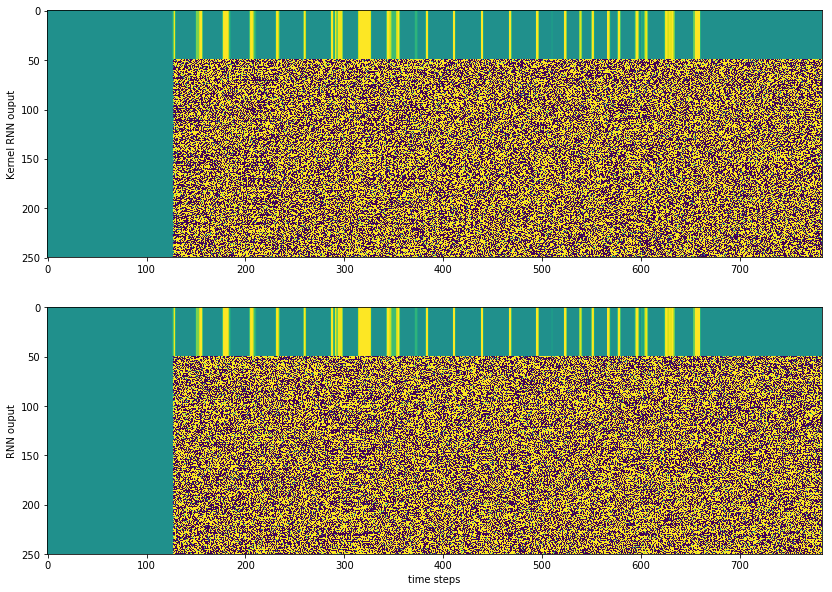

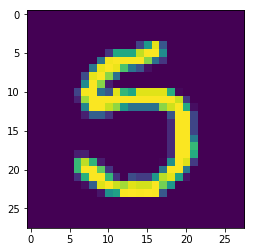

In [160]:
with tf.Session(graph=graph) as sess:
    sess.run(init)
    batch_x,batch_y=mnist.train.next_batch(batch_size)
    batch_x = batch_x.reshape((batch_size, timesteps, num_input))
    kernel_final_class, kernel_outputs=sess.run([kernel_logits, kernel_all_logits], feed_dict={X: batch_x})
    rnn_final_class, rnn_outputs=sess.run([rnn_logits, rnn_all_logits], feed_dict={X: batch_x})
    
outputs_np=np.asarray(kernel_outputs[9])
rnn_ouputs_np=np.asarray(rnn_outputs[9])
plt.figure(figsize=[15,10])
plt.subplot(211)
plt.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),outputs_np.transpose()]))
plt.ylabel('Kernel RNN ouput')
ax=plt.subplot(212)
ax.imshow(np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),rnn_ouputs_np.transpose()]))
plt.ylabel('RNN ouput')
plt.xlabel('time steps')
plt.figure()
plt.imshow(batch_x[9].reshape(28,28))

In [135]:
np.max(outputs_np)
np.max(batch_x[9])


1.0

In [143]:
a=np.vstack([np.tile(np.transpose(batch_x[9]),[50,1]),outputs_np.transpose()])

In [144]:
a.shape

(250, 784)